In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import haversine as hs
import numpy as np

In [2]:
airportdata = pd.read_csv('airports.csv', usecols=[0,1,2,3,4,5,6,7], names=['AirportID','Name','City','Country','IATA','ICAO','Latitude','Longitude'])
airportdata.head()

,AirportID,Name,City,Country,IATA,ICAO,Latitude,Longitude
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001


In [3]:
filePath = 'data/sample_data_DXB.csv'
data = pd.read_csv(filePath)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716049 entries, 0 to 716048
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   airsenseMissionId  716049 non-null  int64  
 1   targetAddress      716049 non-null  int64  
 2   lat                716049 non-null  float64
 3   lon                716049 non-null  float64
 4   alt                716049 non-null  float64
 5   posTime            716049 non-null  int64  
 6   track              665601 non-null  float64
 7   speed              665601 non-null  float64
 8   targetId           713572 non-null  object 
 9   aircraftType       711939 non-null  object 
 10  aircraftReg        711585 non-null  object 
 11  airlineId          709429 non-null  object 
 12  touchdownPosTime   716049 non-null  int64  
 13  takeoffPosTime     716049 non-null  int64  
 14  destination        716049 non-null  object 
 15  origin             716049 non-null  object 
dtypes:

In [4]:
airport_names = pd.unique(data.origin)
airport_names = airport_names.tolist()
airport_names.append('DXB')

In [5]:
locations_own = {}
locations_unknown = {}
for airport_iata in airport_names:
    loc = airportdata.loc[airportdata['IATA']==airport_iata]
    if len(loc)>0:
        locations_own[airport_iata] = [float(loc['Latitude']), float(loc['Longitude'])]
    else:
        locations_unknown[airport_iata] = []

In [6]:
locations_unknown

{'GRV': [], 'NMF': [], 'GSM': [], 'BYB': []}

In [7]:
locations_unknown['GRV'] = [43.38489122958333, 45.700649360330836]
locations_unknown['NMF'] = [5.825289730090683, 73.47753787121358]
locations_unknown['GSM'] = [26.755950801249845, 55.89552228558024]
locations_unknown['BYB'] = [25.614667704625447, 56.24596821808005]

In [8]:
locations_own.update(locations_unknown)

In [19]:
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):

    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

def dist_per_flight(mID, df):
    locs = df.loc[df['airsenseMissionId']==mID, ['lat', 'lon', 'origin', 'destination']].dropna()
    org_dest = locs.iloc[0]
    #print(org_dest)
    orig_name = str(org_dest.origin)
    dest_name = str(org_dest.destination)
    dest = pd.DataFrame({'lat':[locations_own[orig_name][0]], 'lon':[locations_own[orig_name][1]]})
    orig = pd.DataFrame({'lat':[locations_own[dest_name][0]], 'lon':[locations_own[dest_name][1]]})
    locs = pd.concat([orig, locs[['lat', 'lon']], dest],ignore_index=True)
    dist = haversine(locs.lat, locs.lon, locs.lat.shift(-1), locs.lon.shift(-1), to_radians=False).dropna().sum()
    return dist

In [20]:
unique_missions = data['airsenseMissionId'].unique()
distances = []
for mission_ID in unique_missions:
    distances.append(dist_per_flight(mission_ID, data))

(array([  7.,   5.,  12.,  59.,  45.,  28.,  27.,  30.,  35.,  51.,  67.,
         28.,  14.,  44.,  49.,  61., 103., 133., 117.,  85.,  98.,  95.,
         95., 106.,  82.,  61.,  47.,  58.,  57.,  48.,  41.,  39.,  39.,
         18.,  31.,  29.,  38.,  48.,  41.,  27.,  31.,  19.,   9.,  22.,
         13.,  24.,  22.,  16.,  18.,  11.,   8.,   9.,   5.,   4.,   2.,
          3.,   1.,   3.,   6.,   8.,   4.,   9.,   3.,   2.,   3.,   3.,
          4.,   4.,   8.,   7.,   2.,   8.,   4.,   6.,   5.,   4.,   4.,
          3.,   7.,   1.,   5.,   2.,   2.,   9.,   6.,   5.,   4.,   6.,
          1.,   3.,   1.,   1.,   0.,   2.,   1.,   0.,   1.,   1.,   0.,
          2.]),
 array([  45895.23606124,  144728.62801394,  243562.01996665,
         342395.41191935,  441228.80387205,  540062.19582475,
         638895.58777745,  737728.97973015,  836562.37168285,
         935395.76363555, 1034229.15558825, 1133062.54754095,
        1231895.93949365, 1330729.33144635, 1429562.72339905,
        

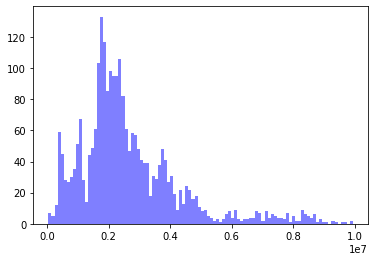

In [22]:
plt.hist(distances, 100, facecolor='blue', alpha=0.5)

In [23]:
dist_per_flight(-6616577058941016649, data)

3102082.3085059365

In [29]:
test = data.loc[data['airsenseMissionId']==-6616577058941016649]
test.head()

,airsenseMissionId,targetAddress,lat,lon,alt,posTime,track,speed,targetId,aircraftType,aircraftReg,airlineId,touchdownPosTime,takeoffPosTime,destination,origin
0,-6616577058941016649,9003895,40.339340,67.717730,38000.0,1614560750000,246.00000,386.00000,FDB1462,B738,A6-FEF,FDB,1614572107930,1614557397516,DXB,FRU
1,-6616577058941016649,9003895,25.273500,55.334420,300.0,1614572091000,121.00000,133.00000,FDB1462,B738,A6-FEF,FDB,1614572107930,1614557397516,DXB,FRU
3702,-6616577058941016649,9003895,25.467892,55.338190,6225.0,1614571668516,249.81812,249.16992,FDB1462,B738,A6-FEF,FDB,1614572107930,1614557397516,DXB,FRU
3703,-6616577058941016649,9003895,25.262490,55.344418,0.0,1614574670602,NaN,NaN,FDB1462,B738,A6-FEF,FDB,1614572107930,1614557397516,DXB,FRU
3704,-6616577058941016649,9003895,25.262491,55.344418,0.0,1614576471766,NaN,NaN,FDB1462,B738,A6-FEF,FDB,1614572107930,1614557397516,DXB,FRU


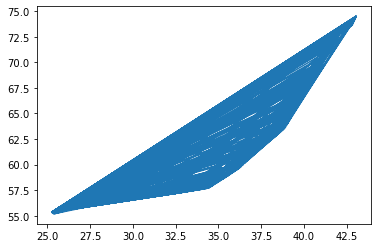

In [28]:
plt.plot(test.lat, test.lon)

In [36]:
grp_obj = data.groupby('takeoffPosTime')

In [38]:
grp_obj.groups.keys()

dict_keys([1614557397516, 1614560605633, 1614560673766, 1614562115625, 1614562789383, 1614563598008, 1614563642000, 1614564702875, 1614565388109, 1614565483477, 1614566542633, 1614567200805, 1614568719172, 1614569441094, 1614569599711, 1614570424039, 1614570441094, 1614571764828, 1614571780836, 1614572209680, 1614572354180, 1614572519414, 1614573136250, 1614573445914, 1614574359383, 1614574396234, 1614574659930, 1614574844797, 1614574989930, 1614575642797, 1614575682977, 1614576164664, 1614576624969, 1614577225625, 1614577797594, 1614577951648, 1614578121313, 1614578322477, 1614578487055, 1614580027375, 1614580483023, 1614580577500, 1614581996273, 1614582126000, 1614582278570, 1614582625938, 1614582868688, 1614583231234, 1614583328406, 1614583690891, 1614583876336, 1614584024703, 1614584351898, 1614584700813, 1614584941258, 1614585114367, 1614585873633, 1614587023250, 1614587606195, 1614588063406, 1614588618047, 1614588685773, 1614588869156, 1614589341383, 1614589855422, 1614590154836,

In [61]:
def dist_per_flight_new(unique_id, df):
    locs = df.loc[df['uniq']==unique_id, ['lat', 'lon', 'origin', 'destination']].dropna()
    org_dest = locs.iloc[0]
    orig_name = str(org_dest.origin)
    dest_name = str(org_dest.destination)
    dest = pd.DataFrame({'lat':[locations_own[orig_name][0]], 'lon':[locations_own[orig_name][1]]})
    orig = pd.DataFrame({'lat':[locations_own[dest_name][0]], 'lon':[locations_own[dest_name][1]]})
    locs = pd.concat([orig, locs[['lat', 'lon']], dest],ignore_index=True)
    dist = haversine(locs.lat, locs.lon, locs.lat.shift(-1), locs.lon.shift(-1), to_radians=False).dropna().sum()
    return dist

In [47]:
distances = []
for ky in grp_obj.groups:
    group = grp_obj.groups[ky]
    print(group)
    #distances.append(dist_per_flight_new(None, grp_obj.groups[ky]))

Int64Index([     0,      1,   3702,   3703,   3704,   7230,   7231,   7232,
              7233,  10879,
            ...
            694522, 698152, 701729, 701730, 701731, 705305, 705306, 705307,
            712434, 712435],
           dtype='int64', length=371)
Int64Index([  7239,  17980,  21564,  32111,  39219,  42734,  46287,  49895,
             60523,  64177,
            ...
            683660, 694527, 698155, 701733, 701734, 701735, 705312, 708851,
            712439, 712440],
           dtype='int64', length=121)
Int64Index([     2,      3,      4,   3705,   3706,   3707,   3708,   7234,
              7235,   7236,
            ...
            701732, 705308, 705309, 705310, 705311, 708849, 708850, 712436,
            712437, 712438],
           dtype='int64', length=639)
Int64Index([  3709,   7240,  17981,  17982,  21565,  21566,  21567,  25090,
             35627,  49896,
            ...
            665590, 665591, 672820, 680085, 680086, 680087, 690875, 698156,
            712

Int64Index([ 65755,  69290,  87030, 126308, 129858, 151585, 155262, 158772,
            165981, 169589, 230120, 258933, 269600, 287470, 362647, 373577,
            395158, 398716, 420153, 423717, 430868, 473858, 477431, 488195,
            506025, 538378, 541982, 577832, 595643, 613330, 663645, 663646,
            688857, 714004],
           dtype='int64')
Int64Index([  1600,   5212,   8844,   8845,  12371,  19588,  19589,  19590,
             19591,  23107,
            ...
            692473, 692474, 692475, 696133, 699717, 699718, 706855, 710410,
            714005, 714006],
           dtype='int64', length=251)
Int64Index([  5221,  23111,  23112,  33671,  37215,  47880,  51462,  55004,
             58540,  69295,  69296,  69297,  69298,  76377,  83447,  90587,
             94169, 104807, 122576, 126319, 147802, 162411, 165989, 169598,
            183770, 187415, 197980, 205067, 219324, 233837, 248205, 248206,
            266135, 283883, 308982, 326867, 341146, 344717, 344718, 348312

Int64Index([ 10292,  10293,  10294,  17374,  20980,  24498,  27979,  27980,
             31521,  35039,
            ...
            654212, 672193, 697566, 701132, 701133, 701134, 701135, 708275,
            708276, 708277],
           dtype='int64', length=108)
Int64Index([  6622,  20982,  45690,  45691,  63595,  70657,  74230,  77742,
            120416, 127741, 141916, 149288, 174492, 178070, 188795, 210085,
            213684, 238971, 246094, 253191, 281705, 299636, 324715, 342543,
            371328, 374973, 385716, 389269, 407159, 439520, 471634, 489620,
            496667, 496668, 511045, 514670, 525416, 546903, 550414, 568333,
            572001, 586420, 600469, 607618, 639707, 643309, 643310, 668563,
            668564, 672195, 683074, 686696, 701138, 711875],
           dtype='int64')
Int64Index([  6621,  10295,  10296,  17375,  20981,  24499,  27981,  31522,
             31523,  31524,
            ...
            675794, 686694, 686695, 690267, 693934, 697567, 701136, 701137

In [48]:
data_new = data

In [57]:
data_new['uniq'] = data_new.apply(lambda row: str(row.airsenseMissionId) +'_'+str(row.takeoffPosTime)+'_'+str(row.touchdownPosTime), axis = 1)

In [58]:
data_new.uniq.iloc[0]

'-6616577058941016649_1614557397516_1614572107930'

In [60]:
len(pd.unique(data_new.uniq))

2475

In [62]:
dists = []
for uniq_name in pd.unique(data_new.uniq):
    dists.append(dist_per_flight_new(uniq_name, data_new))

(array([  7.,   5.,  12.,  59.,  45.,  28.,  27.,  30.,  35.,  51.,  67.,
         28.,  14.,  44.,  49.,  61., 103., 133., 117.,  85.,  98.,  95.,
         95., 106.,  82.,  61.,  47.,  58.,  57.,  48.,  41.,  39.,  39.,
         18.,  31.,  29.,  38.,  48.,  41.,  27.,  31.,  19.,   9.,  22.,
         13.,  24.,  22.,  16.,  18.,  11.,   8.,   9.,   5.,   4.,   2.,
          3.,   1.,   3.,   6.,   8.,   4.,   9.,   3.,   2.,   3.,   3.,
          4.,   4.,   8.,   7.,   2.,   8.,   4.,   6.,   5.,   4.,   4.,
          3.,   7.,   1.,   5.,   2.,   2.,   9.,   6.,   5.,   4.,   6.,
          1.,   3.,   1.,   1.,   0.,   2.,   1.,   0.,   1.,   1.,   0.,
          2.]),
 array([  45895.23606124,  144728.62801394,  243562.01996665,
         342395.41191935,  441228.80387205,  540062.19582475,
         638895.58777745,  737728.97973015,  836562.37168285,
         935395.76363555, 1034229.15558825, 1133062.54754095,
        1231895.93949365, 1330729.33144635, 1429562.72339905,
        

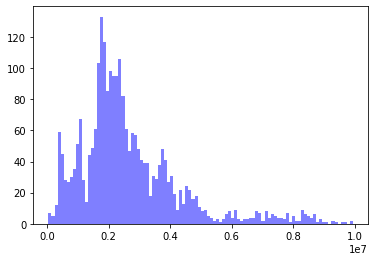

In [63]:
plt.hist(dists, 100, facecolor='blue', alpha=0.5)